# data load

[상세 설명]
FIFA_train.csv
1. id : 선수 고유의 아이디
2. name : 이름
3. age : 나이
4. continent : 선수들의 국적이 포함되어 있는 대륙입니다
5. contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다
6. position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
7. prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
8. reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
9. stat_overall : 선수의 현재 능력치 입니다.
10. stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
11. stat_skill_moves : 선수의 개인기 능력치 입니다.
12. value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다.

평가기준: rmse

핵심은 이상치를 어떻게 다룰 것인가

In [78]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from xgboost import plot_importance
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import numpy as np

In [21]:
def get_score(y_test, pred):
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    return rmse

In [249]:
def load_dataset():
    train = pd.read_csv('data/FIFA_train.csv')
    test = pd.read_csv('data/FIFA_test.csv')
    sub = pd.read_csv('data/submission.csv')
    
    train.drop(['id', 'name'], axis=1, inplace=True)
    test.drop(['id', 'name'], axis=1, inplace=True)
    
    return train, test, sub

train, test, sub = load_dataset()

In [9]:
display(train.shape, train.head())

(8932, 12)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


# data preprocessing

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [13]:
object_cols = train.dtypes[train.dtypes=='object'].index.tolist()

for col in object_cols:
    print(col)
    print(train[col].value_counts())

name
Diego Barri     1
R. Munsy        1
Lekue           1
P. Mortensen    1
J. Andrada      1
               ..
R. McGree       1
N. Julan        1
Illarramendi    1
J. Żubrowski    1
J. Sandoval     1
Name: name, Length: 8932, dtype: int64
continent
europe           5322
south america    1927
asia              787
africa            721
oceania           175
Name: continent, dtype: int64
contract_until
2019            2366
2021            2308
2020            2041
2022             761
2023             506
Jun 30, 2019     501
2018             327
Dec 31, 2018      64
May 31, 2019      19
2024              12
Jan 31, 2019      10
Jun 30, 2020       9
2025               3
Jan 1, 2019        2
May 31, 2020       1
Jan 12, 2019       1
2026               1
Name: contract_until, dtype: int64
position
MF    3428
DF    2791
ST    1705
GK    1008
Name: position, dtype: int64
prefer_foot
right    6837
left     2095
Name: prefer_foot, dtype: int64


## contract_until 전처리

In [250]:
train['contract_until'] = train['contract_until'].apply(lambda x: x[-4:])

## left_contract

In [252]:
train['left_contract'] = train['contract_until'].apply(lambda x: int(x) - 2017)

## 이상치 제거

<AxesSubplot:>

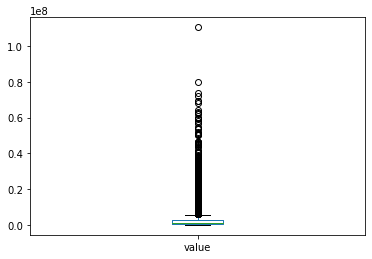

In [205]:
train['value'].plot.box()

In [207]:
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    
    return np.where((data>upper_bound) | (data<lower_bound))

<AxesSubplot:>

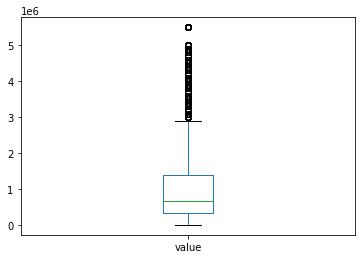

In [212]:
train.drop(outliers_iqr(train['value'])[0])['value'].plot.box()

# EDA

포지션별로 나눠서 살펴볼 필요가 있다.

## corr

<Figure size 1800x1800 with 0 Axes>

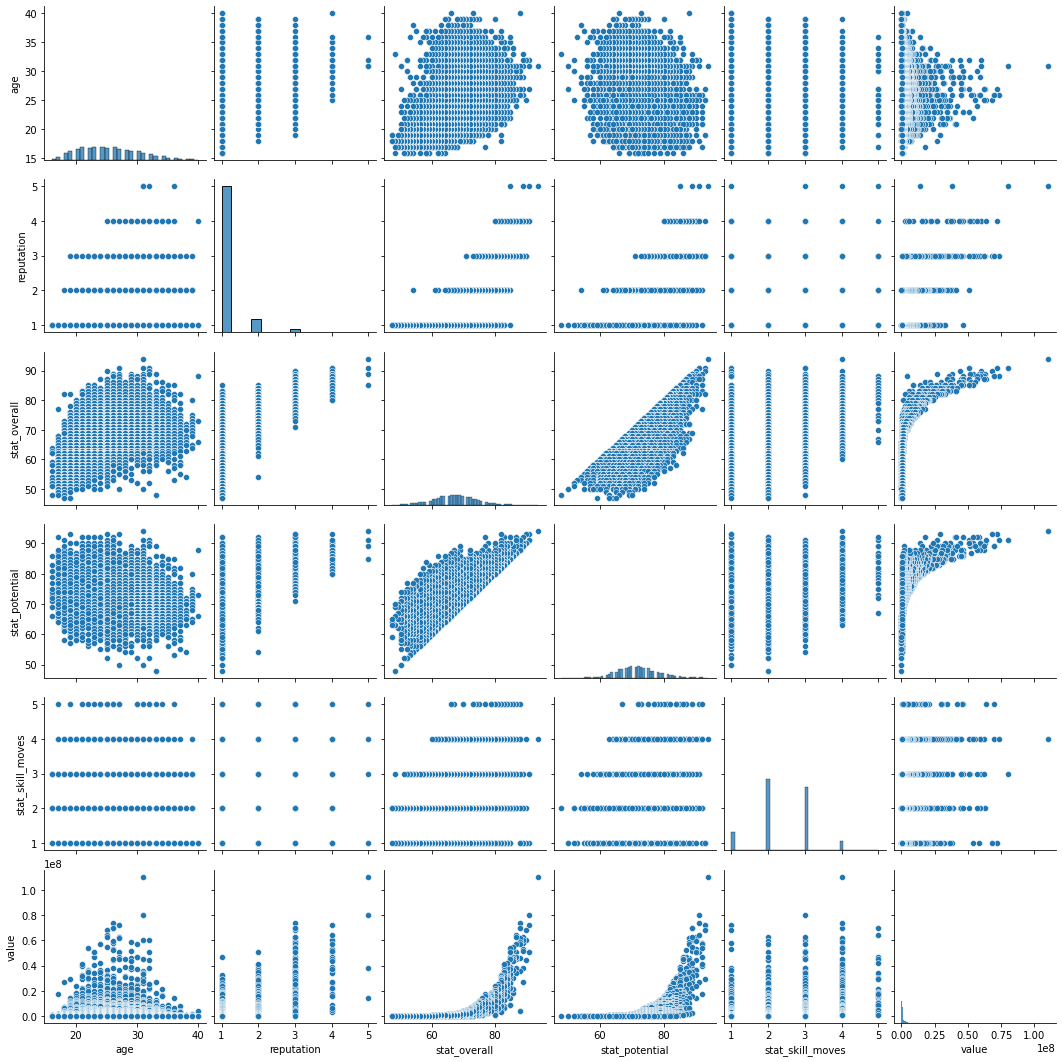

In [24]:
plt.figure(figsize=(25, 25))
sns.pairplot(train)

In [25]:
train.corr()

,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
age,1.000000,0.263468,0.467345,-0.231303,0.039362,0.087319
reputation,0.263468,1.000000,0.521389,0.399183,0.196582,0.665982
stat_overall,0.467345,0.521389,1.000000,0.665453,0.400164,0.658444
stat_potential,-0.231303,0.399183,0.665453,1.000000,0.332578,0.611907
stat_skill_moves,0.039362,0.196582,0.400164,0.332578,1.000000,0.298500
value,0.087319,0.665982,0.658444,0.611907,0.298500,1.000000


In [254]:
train.corr()['value']

age                 0.087319
reputation          0.665982
stat_overall        0.658444
stat_potential      0.611907
stat_skill_moves    0.298500
value               1.000000
left_contract       0.228638
Name: value, dtype: float64

의외로 나이가 상관관계가 낮음

## boxplot

### continuous value

In [29]:
not_object_cols = train.dtypes[train.dtypes!='object'].index.tolist()
not_object_cols.remove('value')

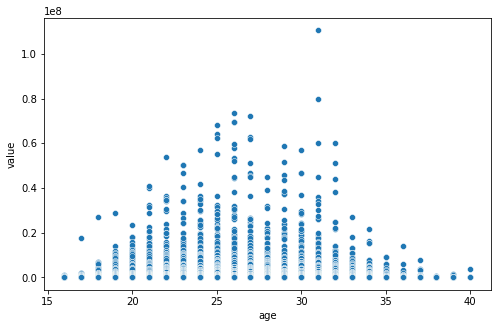

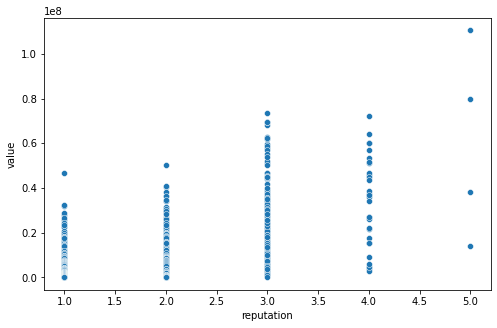

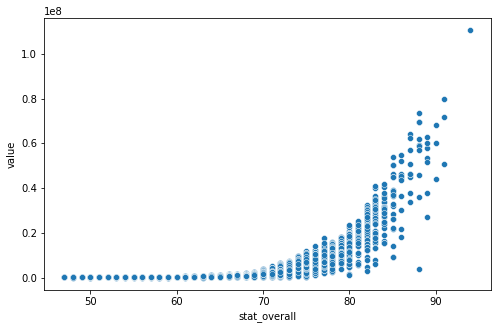

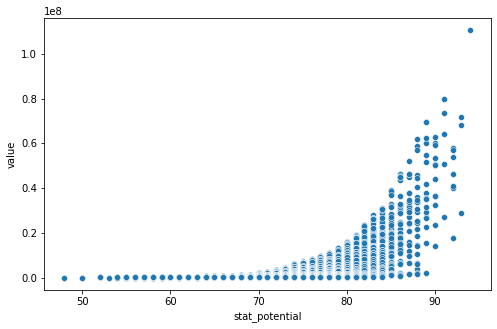

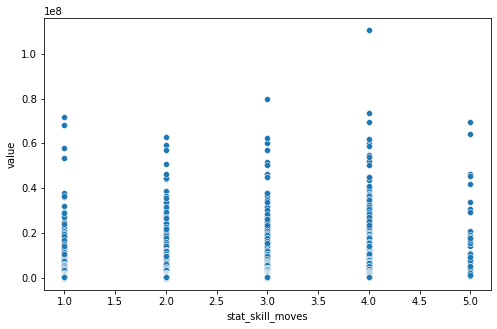

In [31]:
for col in not_object_cols:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=train, x=col, y='value')

stat_overall, stat_potential이 주요 예측변수임을 확인할 수 있음  
(상관관계가 높고 scatter분포상에도 이가 보임)

In [35]:
object_cols = train.dtypes[train.dtypes=='object'].index.tolist()
object_cols

['continent', 'contract_until', 'position', 'prefer_foot']

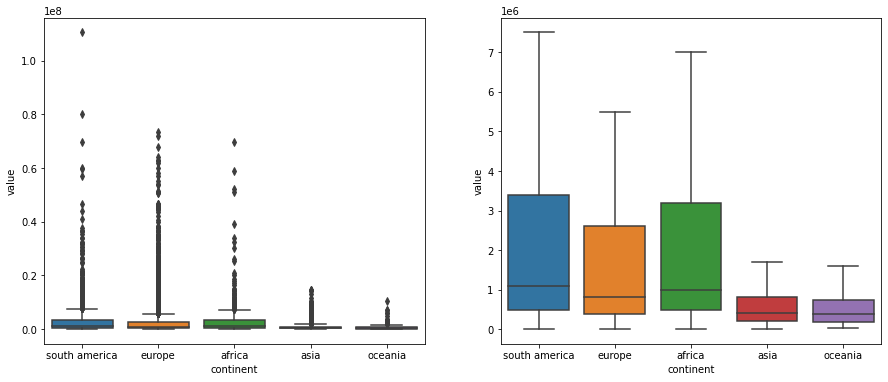

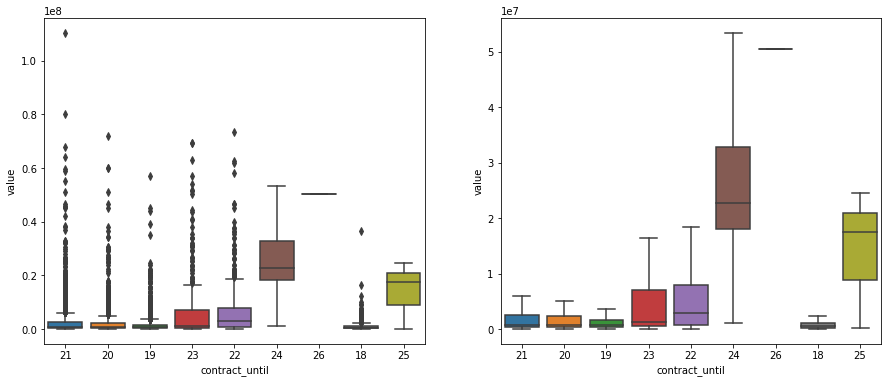

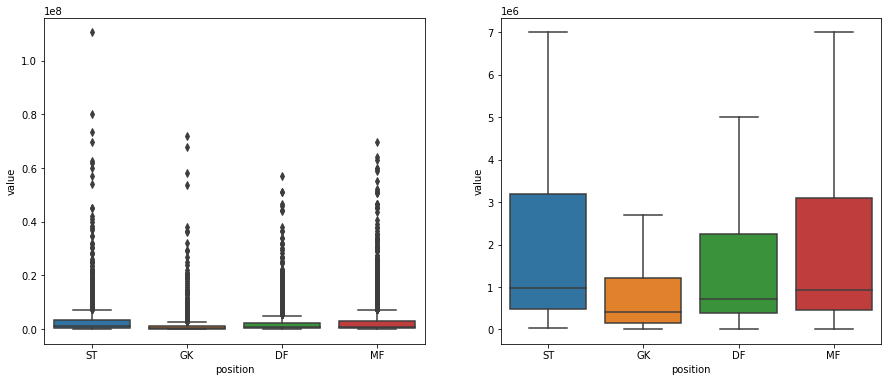

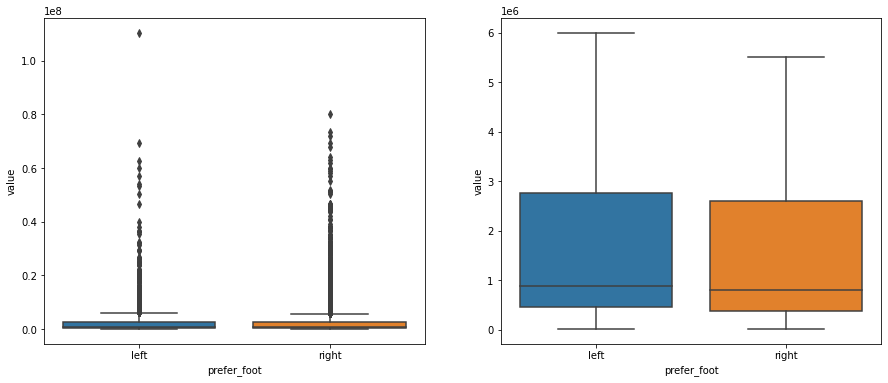

In [98]:
for col in object_cols:
    _, axes = plt.subplots(1, 2, figsize=(15 ,6))
    sns.boxplot(data=train, x=col, y='value', ax=axes[0])
    sns.boxplot(data=train, x=col, y='value', ax=axes[1], showfliers=False)

이상치가 굉장히 많다.  
차이가 보이는 것 : 지역, 포지션  
-지역별로 분명한 차이가 보임  
-계약연도는 특이하게 2024년과 2025년일때가 값이 크다. 길수록 분명한 상관관계가 있어보임.  
-포지션도 직관과 일치하게 차이가 분명히 보임  
없는 것: 주발

## skew확인

5.885798215027292


<AxesSubplot:>

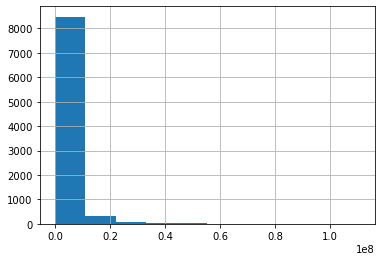

In [39]:
print(train['value'].skew())
train['value'].hist()

In [10]:
np.log1p(train['value']).skew()

0.30879767174080225

# Modeling

In [221]:
train, test, sub = load_dataset()
total = pd.concat([train, test])
get_outliers_ind(train['value'])

(array([   0,    1,    2, ..., 2090, 2098, 2160], dtype=int64),)

In [217]:
def get_outliers_ind(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    
    return np.where((data>upper_bound) | (data<lower_bound))

In [255]:
def preprocessing(df):
    scaler = StandardScaler()
#     scaler = MinMaxScaler()
    scaled_cols = df.dtypes[df.dtypes!='object'].index.tolist()
    df[scaled_cols] = scaler.fit_transform(df[scaled_cols])
    
    object_cols = df.dtypes[df.dtypes=='object'].index.tolist()
    df = pd.get_dummies(df, columns=object_cols)
        
    return df

In [267]:
def get_train_test(is_test=False, drop_cols=None, drop_outliers=False):
    train, test, sub = load_dataset()
    if drop_outliers:
        outliers_ind = get_outliers_ind(train['value'])[0]
        train.drop(outliers_ind, inplace=True)
    target = train['value']
    
    total = pd.concat([train, test])
    total['contract_until'] = total['contract_until'].apply(lambda x: x[-4:])
    total['left_contract'] = total['contract_until'].apply(lambda x: int(x) - 2017)
    
    if drop_cols != None:
        total.drop(drop_cols, axis=1, inplace=True)
    total = preprocessing(total)
    
    train = total[~total['value'].isna()]
    test = total[total['value'].isna()]
    test.drop(['value'], axis=1,inplace=True)
    
    ftr_x = train.drop(['value'], axis=1)
        
    if is_test:
        return test
    else:
        return ftr_x, target

In [50]:
def scorer(model, X, y):
    pred = model.predict(X)
    rmse = get_score(y, pred)
    return rmse

In [224]:
def fit_test(model, drop_cols=None, drop_outliers=False):
    ftr_x, target = get_train_test(drop_cols=drop_cols, drop_outliers=drop_outliers)
    scores = cross_val_score(model, ftr_x, target, scoring=scorer, cv=30)
    return np.mean(scores)

In [229]:
def make_sub(model, drop_cols=None, drop_outliers=False):
    ftr_x, target = get_train_test(drop_cols=drop_cols, drop_outliers=drop_outliers)
    test = get_train_test(True, drop_cols=drop_cols)
    model.fit(ftr_x, target)
    pred = model.predict(test)
    sub['value'] = pred
    return sub

In [237]:
def plot_coef(model, drop_cols=None, drop_outliers=False):
    ftr_x, target = get_train_test(drop_cols=drop_cols, drop_outliers=drop_outliers)
    
    model.fit(ftr_x, target)
    
    coef = pd.Series(data=model.coef_, index=ftr_x.columns)
    coef.sort_values(ascending=False, inplace=True)
    
    plt.figure(figsize=(12, 12))
    sns.barplot(coef.values, coef.index)

## another models

In [328]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## lr_models

In [304]:
lr_reg = LinearRegression()
lasso_reg = Lasso(alpha=255.08402606280637)
ridge_reg = Ridge()
elasticnet_reg = ElasticNet(alpha=3.85259163522376, l1_ratio=0.9920542810567496)

models = [lr_reg, lasso_reg, ridge_reg, elasticnet_reg]
for model in models:
    print(model.__class__)
    print(fit_test(model, drop_outliers=True))

<class 'sklearn.linear_model._base.LinearRegression'>
684696.5400514007
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
684308.6966329289
<class 'sklearn.linear_model._ridge.Ridge'>
684555.5582840297
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
679284.2500760873


In [308]:
elasticnet_reg = ElasticNet(alpha=3.85259163522376, l1_ratio=0.9920542810567496)
print(fit_test(model, drop_outliers=True, drop_cols=['stat_potential', 'contract_until']))

673483.9007392352


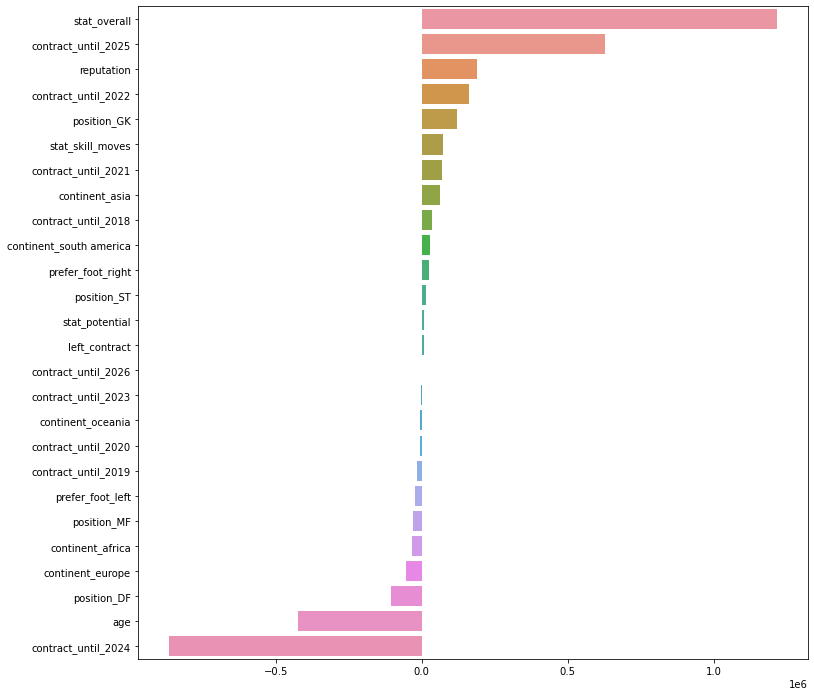

In [269]:
plot_coef(lr_reg, drop_outliers=True)

## tuning

### ridge

In [295]:
ftr_x, target = get_train_test(drop_outliers=True)
# train_x, valid_x, train_y, valid_y = train_test_split(ftr_x, target, test_size=0.2)

bayesian_params = {
    'a':(220, 260)
}

def ridge_eval(a):
    ridge = Ridge(alpha=a)
    scores = cross_val_score(ridge, ftr_x, target, cv=30, scoring=scorer)
    
    return -np.mean(scores)

In [296]:
ridgeBO = BayesianOptimization(ridge_eval, bayesian_params)
ridgeBO.maximize(init_points=10, n_iter=50)

|   iter    |  target   |     a     |
-------------------------------------
|  1        | -6.793e+0 |  222.6    |
|  2        | -6.793e+0 |  244.1    |
|  3        | -6.793e+0 |  241.0    |
|  4        | -6.793e+0 |  233.2    |
|  5        | -6.793e+0 |  233.5    |
|  6        | -6.793e+0 |  239.4    |
|  7        | -6.793e+0 |  238.6    |
|  8        | -6.793e+0 |  255.9    |
|  9        | -6.793e+0 |  236.6    |
|  10       | -6.793e+0 |  232.5    |
|  11       | -6.793e+0 |  260.0    |
|  12       | -6.793e+0 |  252.3    |
|  13       | -6.793e+0 |  254.5    |
|  14       | -6.793e+0 |  255.1    |
|  15       | -6.793e+0 |  255.1    |
|  16       | -6.793e+0 |  255.1    |
|  17       | -6.793e+0 |  255.1    |
|  18       | -6.793e+0 |  255.1    |
|  19       | -6.793e+0 |  255.1    |
|  20       | -6.793e+0 |  255.1    |
|  21       | -6.793e+0 |  254.8    |
|  22       | -6.793e+0 |  255.2    |
|  23       | -6.793e+0 |  255.2    |
|  24       | -6.793e+0 |  254.9    |
|  25       

In [297]:
results = []
for result in ridgeBO.res:
    results.append(result['target'])
max_ind = np.argmax(results)
ridgeBO.res[max_ind]

{'target': -679262.6363029957, 'params': {'a': 255.08402606280637}}

### lasso

In [298]:
ftr_x, target = get_train_test(drop_outliers=True)
# train_x, valid_x, train_y, valid_y = train_test_split(ftr_x, target, test_size=0.2)

bayesian_params = {
    'a':(0, 20)
}

def lasso_eval(a):
    ridge = Lasso(alpha=a)
    scores = cross_val_score(ridge, ftr_x, target, cv=30, scoring=scorer)
    
    return -np.mean(scores)

In [299]:
lassoBO = BayesianOptimization(lasso_eval, bayesian_params)
lassoBO.maximize(init_points=10, n_iter=50)

|   iter    |  target   |     a     |
-------------------------------------
|  1        | -6.846e+0 |  19.54    |
|  2        | -6.846e+0 |  4.389    |
|  3        | -6.846e+0 |  11.42    |
|  4        | -6.846e+0 |  19.35    |
|  5        | -6.846e+0 |  10.95    |
|  6        | -6.846e+0 |  14.21    |
|  7        | -6.846e+0 |  19.5     |
|  8        | -6.846e+0 |  7.989    |
|  9        | -6.846e+0 |  16.81    |
|  10       | -6.846e+0 |  13.59    |
|  11       | -6.846e+0 |  0.0      |
|  12       | -6.846e+0 |  0.0      |
|  13       | -6.846e+0 |  0.0      |
|  14       | -6.846e+0 |  0.0      |
|  15       | -6.846e+0 |  0.0      |
|  16       | -6.846e+0 |  0.0      |
|  17       | -6.846e+0 |  0.0      |
|  18       | -6.846e+0 |  0.0      |
|  19       | -6.846e+0 |  0.0      |
|  20       | -6.846e+0 |  0.0      |
|  21       | -6.846e+0 |  0.0      |
|  22       | -6.846e+0 |  0.0      |
|  23       | -6.846e+0 |  0.0      |
|  24       | -6.846e+0 |  0.0      |
|  25       

In [300]:
results = []
for result in lassoBO.res:
    results.append(result['target'])
max_ind = np.argmax(results)
lassoBO.res[max_ind]

{'target': -684575.4757331769, 'params': {'a': 0.0}}

### elasticnet

In [135]:
from bayes_opt import BayesianOptimization

In [301]:
ftr_x, target = get_train_test(drop_outliers=True)
# train_x, valid_x, train_y, valid_y = train_test_split(ftr_x, target, test_size=0.2)

bayesian_params = {
    'a':(0, 10),
    'r':(0, 1)
}

def elasticnet_eval(a, r):
    elasticnet = ElasticNet(alpha=a, l1_ratio=r)
    scores = cross_val_score(elasticnet, ftr_x, target, cv=30, scoring=scorer)
    
    return -np.mean(scores)

In [302]:
elasticnetBO = BayesianOptimization(elasticnet_eval, bayesian_params)
elasticnetBO.maximize(init_points=10, n_iter=50)

|   iter    |  target   |     a     |     r     |
-------------------------------------------------
|  1        | -7.32e+05 |  3.087    |  0.5977   |
|  2        | -7.263e+0 |  3.81     |  0.6971   |
|  3        | -9.28e+05 |  9.032    |  0.1831   |
|  4        | -6.819e+0 |  0.128    |  0.9432   |
|  5        | -7.053e+0 |  1.513    |  0.4673   |
|  6        | -8.032e+0 |  8.316    |  0.7125   |
|  7        | -9.234e+0 |  9.422    |  0.2563   |
|  8        | -6.906e+0 |  1.185    |  0.6004   |
|  9        | -7.162e+0 |  3.764    |  0.7362   |
|  10       | -7.082e+0 |  7.78     |  0.8898   |
|  11       | -6.846e+0 |  6.393    |  1.0      |
|  12       | -6.846e+0 |  0.0      |  0.0      |
|  13       | -9.202e+0 |  6.761    |  0.0      |
|  14       | -6.846e+0 |  5.334    |  1.0      |
|  15       | -7.073e+0 |  0.8486   |  0.007994 |
|  16       | -6.846e+0 |  2.162    |  1.0      |
|  17       | -6.846e+0 |  7.114    |  1.0      |
|  18       | -6.846e+0 |  0.8082   |  1.0      |


In [303]:
results = []
for result in elasticnetBO.res:
    results.append(result['target'])
max_ind = np.argmax(results)
elasticnetBO.res[max_ind]

{'target': -679284.2500760873,
 'params': {'a': 3.85259163522376, 'r': 0.9920542810567496}}

## StepWise

In [305]:
elasticnet_reg = ElasticNet(alpha=3.85259163522376, l1_ratio=0.9920542810567496)

In [306]:
from itertools import combinations

cols = train.columns.tolist()
cols.remove('value')
cols.remove('contract_until')

results = {}

for i in range(len(cols)):
    combi = combinations(cols, i)
    combi = list(combi)
    for cand in combi:
        drop_cols = list(cand)
        drop_cols.append('contract_until')
        result = fit_test(elasticnet_reg, drop_cols=drop_cols, drop_outliers=True)
        results[result] = drop_cols

best_ind = np.argmin(list(results.keys()))
print('best_result:', np.min(list(results.keys())))
print('drop_cols:', list(results.values())[best_ind])

best_result: 673483.9007392352
drop_cols: ['stat_potential', 'contract_until']


# Sub

In [321]:
lr_reg = LinearRegression()
make_sub(lr_reg).to_csv('sub/lr_reg_01.csv', index=False)
# fit_test: 2772703.535359487
# public score: 4443087.567724295

In [323]:
lr_reg = LinearRegression()
make_sub(lr_reg, drop_outliers=True).to_csv('sub/lr_reg_02.csv', index=False)
# fit_test: 684696.5400514007
# public score: 6596904.681633226

In [198]:
elasticnet_reg = ElasticNet(alpha = 5.184306651296048, l1_ratio = 0.7263784196125636)
make_sub(elasticnet_reg, drop_cols=['contract_until']).to_csv('sub/elasticnet_reg_01.csv', index=False)
# fit_test: 2544281.8002038
# public score: 4857489.5730088595
# drop: contract_until
# one-hot encoding, StandardScaler

In [199]:
elasticnet_reg = ElasticNet(alpha = 2.9498505117199167, l1_ratio = 0.54645574455199)
drop_cols = ['age', 'continent', 'stat_skill_moves', 'contract_until']
make_sub(elasticnet_reg, drop_cols=drop_cols).to_csv('sub/elasticnet_reg_02.csv', index=False)
# fit_test: 2428356.67502821
# public: 5338012.188111597
# drop: ['age', 'continent', 'stat_skill_moves', 'contract_until']
# one-hot encoding, StandardScaler

In [309]:
elasticnet_reg = ElasticNet(alpha=3.85259163522376, l1_ratio=0.9920542810567496)
make_sub(elasticnet_reg, drop_outliers=True).to_csv('sub/elasticnet_reg_03.csv', index=False)
# fit_test: 679284.2500760873
# public: 6640307.798027223
# one-hot-encoding, StandardScaler
# drop outliers

In [310]:
elasticnet_reg = ElasticNet(alpha=3.85259163522376, l1_ratio=0.9920542810567496)
drops_cols = ['stat_potential', 'contract_until']
make_sub(elasticnet_reg, drop_outliers=True, drop_cols=drop_cols).to_csv('sub/elasticnet_reg_04.csv', index=False)
# fit_test: 673483.9007392352
# public: 7469429.5228845505
# drop: ['stat_potential', 'contract_until']
# one-hot encoding, StandardScaler
# drop outliers